# Experiments Orchestration

This notebook is intened to be used to carry out scientific experiments for the following configurations:

---

## Experiment 4: All Models vs Pruned Model Convergence
- **Goal**: Check if the performance of a growing ensemble and the prunned version converges.
- **Presentation**: Graph
- **Static Parameters**:
  - Randomization factor: `rand = 2.0`
  - Pruned size: 15 models
- **Configurations**:
  - `ALL MODELS`
  - `PRUNED MAX-IMV`
  - `PRUNED AFFINITY`
- **Varying Parameter**:
  - Total number of models: [15 ... 1000]
- **Datasets**:
  - Random Machines 3–4
  - HDFS
- **Repetitions**: 2 trials per configuration

---

## Setup

- **Output**:
  - All results saved as `.csv`
  - Summary tables with mean ± stdev
  - Graphs showing trends (e.g., accuracy vs. number of models)




In [1]:
%config InlineBackend.figure_format = 'svg'

# === IMPORTS ===

import time
import random
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import kmedoids
from tqdm import tqdm
import matplotlib.pyplot as plt

from pdfa import PDFA
import machines
import ffutils as ff
from ffutils import Model, TestConfig, TrainRun, TestRun, ModelType, EnsMode, VoteStrat
import variety as var
from export import import_pdfa_json, ResultsManager
from cache import Cache
from clock import SimpleClock


# === GLOBAL OBJECTS ===

CORES = 12
CACHE = Cache()
CLOCK = SimpleClock()
RESULTS_DIR = "./../results/"
RESULTS = ResultsManager(RESULTS_DIR)

STANDARD_TEST = ff.create_standard_config("test")
REBER_CONFIG = ff.create_standard_config("reber")
PARITY_CONFIG = ff.create_standard_config("parity")
PAUTOMAC_TEST = TestConfig(
    name = "PAutomaC",
    dir = "PAutomaC-competition_sets",
    train_suffix = ".pautomac.train.dat",
    model_suffix = ".pautomac.train.dat.ff",
    solution_suffix = ".pautomac_solution.txt",
    test_suffix = ".pautomac.test.dat"
)

def RANDOM_CONFIG(id: int) -> TestConfig:
    return ff.create_standard_config(f"random_{id}", dir="random")

def RANDOM_MACHINE(id: int) -> PDFA:
    return import_pdfa_json(pdfa_name=f"random_{id}", input_file=f"./../models/random_{id}.json")

In [2]:
def init_random(seed: int|None = None) -> int:
    if not seed:
        seed = int(time.time() * 1000) % (2**32)  # Generate a time-based seed
    random.seed(seed)
    np.random.seed(seed)
    return seed


def reshape_scores(scores: List[float], num_models: int) -> List[List[float]]:
    return [scores[i:i + num_models] for i in range(0, len(scores), num_models)]


def read_results_into_df(
    experiment_name: str,
    datasets: List[str],
    variations: List[str] = [""]
) -> pd.DataFrame:
    """
    Output DataFrame will have columns: dataset, train_size, model, run_no, score
    """
    
    # Read the results and params files
    records = []
    for dataset in datasets:
        for var in variations:
            props = RESULTS.read_properties(experiment_name, dataset_name=dataset, suffix=var)
            results = RESULTS.read_run_results(experiment_name, dataset_name=dataset, suffix=var)

            # For each result file extract the scores
            for model, scores in results.items():
                for run_no, score in enumerate(scores):
                    records.append({
                        "dataset": dataset,
                        "train_size": int(props["trainset_size"]),
                        "model": model,
                        "run_no": run_no,
                        "score": float(score)
                    })
    return pd.DataFrame(records)

***

## Experiment 1: Single vs Ensemble Performance
- **Goal**: Compare performance of a single model vs an ensemble.
- **Presentation**: Table
- **Static Parameters**:
  - Ensemble size: 20
- **Configurations**:
  - `SINGLE`
  - `GREEDY(rand=1.5)`
  - `GREEDY(rand=3.0)`
- **Datasets**:
  - Parity Machine
  - Reber Machine
  - Random Machines 1–4
  - Selected PAutomaC sets
  - HDFS (real-life software dataset)
- **Repetitions**: 50 trials per configuration

In [ ]:
def run_experiment_1(
    config: TestConfig,
    dataset: str,
    machine: PDFA,
    models: list[Model],
    trainset_size: int,
    testset_size: int,
    runs: int,
    suffix: str = "",
    continue_work: bool = True
):
    CLOCK.start()

    # 0) Write the experiment properties
    global_params: Dict[str, str] = {
        "experiment": "experiment_1",
        "dataset": dataset,
        "runs": str(runs),
        "models": str.join(";", [m.model_name for m in models]),
        "trainset_size": str(trainset_size),
        "testset_size": str(testset_size),
        "seed": str(init_random())
    }
    results_path = RESULTS.get_dataset_dir(global_params["experiment"], global_params["dataset"])
    if not continue_work:
        RESULTS.write_properties(global_params["experiment"], global_params["dataset"], global_params, suffix=suffix)
    print(f"Storing results in {results_path}")

    # 1) Generate all training sets and a test set
    testset = f"{config.name}_exp_{testset_size}"
    trainset_prefix = f"{config.name}_exp_{trainset_size}"
    train_runs: List[TrainRun] = []

    if not continue_work:
        ff.write_testset(testset_name=testset, config=config, pdfa=machine, size=testset_size)
    for run_number in range(runs):
        trainset = trainset_prefix + f"_{run_number}"
        if not continue_work:
            ff.write_trainset(trainset_name=trainset, config=config, pdfa=machine, size=trainset_size)

        for model in models:
            train_runs.append(model.into_run(run_name=str(run_number), trainset_name=trainset, continue_work=True))
    if not continue_work:
        print(f"Created {runs} trainsets of size {trainset_size} and testset {testset}: {CLOCK.measure()}")

    # 2) Train the models
    # print("\n".join(map(str, train_runs)))
    # return
    ff.train_models_batch(config, train_runs, number_of_cores=10)
    print(f"Trained {len(models)} models for {runs} runs: {CLOCK.measure()}")

    # 3) Test the models
    test_runs = TestRun.from_train_runs(train_runs, testset_name=testset)
    scores_flat = ff.test_models_batch(config, test_runs)
    print(f"Tested {len(models)} models for {runs} runs: {CLOCK.measure()}")

    # 4) Collect and write the results
    scores_grouped = reshape_scores(scores_flat, len(models))
    RESULTS.write_run_results(
        global_params["experiment"], 
        global_params["dataset"], 
        [m.model_name for m in models],
        scores_grouped,
        suffix=suffix
    )
    print(f"Finished {global_params["experiment"]} in total time: {CLOCK.stop()}")

In [4]:
# EXPERIMENT 1.

exp_1_models = [
    Model.Single("SINGLE"),
    Model.Greedy("GREEDY_15", rand=1.5, nrestimators=20),
    Model.Greedy("GREEDY_30", rand=3.0, nrestimators=20)
]

In [9]:
# Perform EXPERIMENT 1. on REBER
run_experiment_1(
    config=ff.create_standard_config("exp_1", dir="reber"),
    machine=machines.reber(),
    dataset="reber",
    models=exp_1_models,
    trainset_size=35,
    testset_size=300,
    runs=50
)

Storing results in ./../results/experiment_1\reber
Tested 3 models for 50 runs: 0m 17s
Finished experiment_1 in total time: 0m 17s


In [10]:
# Perform EXPERIMENT 1. on RANDOM_1
run_experiment_1(
    config=ff.create_standard_config("random_1_exp_1", dir="random"),
    machine=RANDOM_MACHINE(1),
    dataset="random_1",
    models=exp_1_models,
    trainset_size=300,
    testset_size=1000,
    runs=50
)

Storing results in ./../results/experiment_1\random_1
Tested 3 models for 50 runs: 1m 47s
Finished experiment_1 in total time: 1m 47s


In [11]:
# Perform EXPERIMENT 1. on RANDOM_2
run_experiment_1(
    config=ff.create_standard_config("random_2_exp_1", dir="random"),
    machine=RANDOM_MACHINE(2),
    dataset="random_2",
    models=exp_1_models,
    trainset_size=250,
    testset_size=1000,
    runs=50
)

Storing results in ./../results/experiment_1\random_2
Tested 3 models for 50 runs: 0m 59s
Finished experiment_1 in total time: 0m 59s


In [12]:
# Perform EXPERIMENT 1. on RANDOM_3
run_experiment_1(
    config=ff.create_standard_config("random_3_exp_1", dir="random"),
    machine=RANDOM_MACHINE(3),
    dataset="random_3",
    models=exp_1_models,
    trainset_size=350,
    testset_size=1000,
    runs=50
)

Storing results in ./../results/experiment_1\random_3
Tested 3 models for 50 runs: 0m 45s
Finished experiment_1 in total time: 0m 45s


In [13]:
# Perform EXPERIMENT 1. on RANDOM_4
run_experiment_1(
    config=ff.create_standard_config("random_4_exp_1", dir="random"),
    machine=RANDOM_MACHINE(4),
    dataset="random_4",
    models=exp_1_models,
    trainset_size=150,
    testset_size=1000,
    runs=50
)

Storing results in ./../results/experiment_1\random_4
Tested 3 models for 50 runs: 3m 45s
Finished experiment_1 in total time: 3m 45s


In [ ]:
# Perform EXPERIMENT 1. on REBER
run_experiment_1(
    config=ff.create_standard_config("reber_exp_1_dense", dir="reber"),
    machine=machines.reber(),
    dataset="reber",
    models=exp_1_models,
    trainset_size=80,
    testset_size=300,
    runs=50,
    suffix="_dense"
)

# Perform EXPERIMENT 1. on RANDOM_1
run_experiment_1(
    config=ff.create_standard_config("random_1_exp_1_dense", dir="random"),
    machine=RANDOM_MACHINE(1),
    dataset="random_1",
    models=exp_1_models,
    trainset_size=900,
    testset_size=1000,
    runs=50,
    suffix="_dense"
)

# Perform EXPERIMENT 1. on RANDOM_2
run_experiment_1(
    config=ff.create_standard_config("random_2_exp_1_dense", dir="random"),
    machine=RANDOM_MACHINE(2),
    dataset="random_2",
    models=exp_1_models,
    trainset_size=700,
    testset_size=1000,
    runs=50,
    suffix="_dense"
)

# Perform EXPERIMENT 1. on RANDOM_3
run_experiment_1(
    config=ff.create_standard_config("random_3_exp_1_dense", dir="random"),
    machine=RANDOM_MACHINE(3),
    dataset="random_3",
    models=exp_1_models,
    trainset_size=1000,
    testset_size=1000,
    runs=50,
    suffix="_dense"
)


Storing results in ./../results/experiment_1\reber
Created 50 trainsets of size 80 and testset reber_exp_1_dense_exp_300: 0m 0s
Trained 3 models for 50 runs: 0m 5s
Tested 3 models for 50 runs: 0m 18s
Finished experiment_1 in total time: 0m 24s
Storing results in ./../results/experiment_1\random_1
Created 50 trainsets of size 900 and testset random_1_exp_1_dense_exp_1000: 0m 2s
Trained 3 models for 50 runs: 16m 49s
Tested 3 models for 50 runs: 1m 44s
Finished experiment_1 in total time: 18m 36s
Storing results in ./../results/experiment_1\random_2
Created 50 trainsets of size 700 and testset random_2_exp_1_dense_exp_1000: 0m 0s
Trained 3 models for 50 runs: 3m 9s
Tested 3 models for 50 runs: 0m 54s
Finished experiment_1 in total time: 4m 5s
Storing results in ./../results/experiment_1\random_3
Created 50 trainsets of size 1000 and testset random_3_exp_1_dense_exp_1000: 0m 0s
Trained 3 models for 50 runs: 12m 32s
Tested 3 models for 50 runs: 0m 40s
Finished experiment_1 in total time: 13

In [8]:
# Perform EXPERIMENT 1. on RANDOM_4
run_experiment_1(
    config=ff.create_standard_config("random_4_exp_1_dense", dir="random"),
    machine=RANDOM_MACHINE(4),
    dataset="random_4",
    models=exp_1_models,
    trainset_size=600,
    testset_size=1000,
    runs=50,
    suffix="_dense"
)

Storing results in ./../results/experiment_1\random_4
Trained 3 models for 50 runs: 86m 29s
Tested 3 models for 50 runs: 2m 12s
Finished experiment_1 in total time: 88m 41s


In [ ]:


def generate_exp_1_table(df: pd.DataFrame) -> str:
    """
    Given a DataFrame indexed by (dataset, train_size, model, run_no) with a 'score' column,
    this function creates a LaTeX table showing:
    - Best score (lowest perplexity across all runs/models for that dataset/train_size)
    - Relative growth in perplexity to best (mean ± std) for each model
    """

    # Compute mean and std per configuration
    summary = df.groupby(['dataset', 'train_size', 'model'])['score'].agg(['mean', 'std']).reset_index()

    # Determine true best score per (dataset, train_size) over all runs/models
    best_scores = df.groupby(['dataset', 'train_size'])['score'].min().reset_index()
    best_scores = best_scores.rename(columns={'score': 'best_score'})

    # Merge with summary
    summary = summary.merge(best_scores, on=['dataset', 'train_size'])

    # Compute growth to best
    summary['growth'] = summary['mean'] - summary['best_score']

    # Format "mean ± std" for growth
    summary['growth_fmt'] = summary.apply(lambda row: f"{row['growth']:.1f} \\pm {row['std']:.1f}", axis=1)
    print(summary)

    # Format for best score
    summary['best_score_fmt'] = summary.apply(lambda row: f"{row['best_score']:.1f}", axis=1)

    # Pivot to wide format
    pivot = summary.pivot(index=['dataset', 'train_size', 'best_score_fmt'], columns='model', values='growth_fmt').reset_index()
    pivot = pivot.sort_values(by=['dataset', 'train_size'])

    # Define the model order
    model_order = ['SINGLE', 'GREEDY_15', 'GREEDY_30']
    pivot = pivot[['dataset', 'train_size', 'best_score_fmt'] + model_order]

    # Build multi-index header
    column_tuples = [
        ("Dataset", ""),
        ("Train size", ""),
        ("Best score", ""),
        ("Avg. perplexity growth to best", "SINGLE"),
        ("Avg. perplexity growth to best", "GREEDY_15"),
        ("Avg. perplexity growth to best", "GREEDY_30")
    ]
    pivot.columns = pd.MultiIndex.from_tuples(column_tuples)

    # Generate LaTeX
    latex_table = pivot.to_latex(index=False, multicolumn=True, multicolumn_format='c', escape=False)

    return latex_table


In [ ]:
exp_1_datasets = ["reber", "random_1", "random_2", "random_3", "random_4"]

exp_1_df = read_results_into_df("experiment_1", exp_1_datasets, ["", "_dense"])
exp_1_df[:100]

,dataset,train_size,model,run_no,score
0,reber,35,SINGLE,0,51.0835
1,reber,35,SINGLE,1,103.7750
2,reber,35,SINGLE,2,53.9769
3,reber,35,SINGLE,3,233.9770
4,reber,35,SINGLE,4,52.9094
...,...,...,...,...,...
95,reber,35,GREEDY_15,45,51.9446
96,reber,35,GREEDY_15,46,92.0173
97,reber,35,GREEDY_15,47,78.0267
98,reber,35,GREEDY_15,48,50.5735


In [38]:
exp_1_table = generate_exp_1_table(exp_1_df)
RESULTS.write_latex_table("experiment_1", exp_1_table)

     dataset  train_size      model        mean         std  best_score  \
0   random_1         300  GREEDY_15   57.829142    6.395283     49.3445   
1   random_1         300  GREEDY_30   58.048008    5.285031     49.3445   
2   random_1         300     SINGLE   93.263188   53.139478     49.3445   
3   random_1         900  GREEDY_15   49.309260    1.705403     48.6275   
4   random_1         900  GREEDY_30   49.190126    0.773041     48.6275   
5   random_1         900     SINGLE   71.171352   51.892641     48.6275   
6   random_2         250  GREEDY_15  105.991438   15.141936     81.3266   
7   random_2         250  GREEDY_30  107.604372   10.250382     81.3266   
8   random_2         250     SINGLE  180.732068   67.670483     81.3266   
9   random_2         700  GREEDY_15   70.397572    2.427622     68.7686   
10  random_2         700  GREEDY_30   70.640908    1.146085     68.7686   
11  random_2         700     SINGLE   76.601082   13.420898     68.7686   
12  random_3         350 

In [4]:
# Generate latex table for EXPERIMENT 1.
RESULTS.generate_latex_table_for_experiment(
    "experiment_1",
    ["reber", "random_1", "random_2", "random_3", "random_4"],
    [m.model_name for m in exp_1_models]
)

'\\begin{tabular}{|l|l|S[table-format=3.1(3)]|S[table-format=3.1(3)]|S[table-format=3.1(3)]||}\n\\hline\nDataset & Train Size & {SINGLE} & {GREEDY 15} & {GREEDY 30} \\\\\n\\hline\nreber & 35 & 164.3 & 0.78 \\pm 0.31 & 0.77 \\pm 0.39 \\\\\nrandom 1 & 300 & 93.3 & 0.73 \\pm 0.23 & 0.73 \\pm 0.21 \\\\\nrandom 2 & 250 & 180.7 & 0.66 \\pm 0.22 & 0.68 \\pm 0.25 \\\\\nrandom 3 & 350 & 529.7 & 0.49 \\pm 0.19 & 0.55 \\pm 0.24 \\\\\nrandom 4 & 150 & 47.4 & 0.78 \\pm 0.31 & 0.76 \\pm 0.32 \\\\\n\\hline\n\\end{tabular}'

***

## Experiment 2: Single vs Ensemble Convergence
- **Goal**: Compare the convergence speed and stability of a single model and ensemble with growing trainset size
- **Presentation**: Graph
- **Configurations**:
  - `SINGLE`
  - `GREEDY(ens=20, rand=2.0)`
- **Varying Parameter**:
  - Training set size depending on the problem
- **Datasets**:
  - Reber Machine
  - Random Machines 1–4
- **Repetitions**: 50 trials per configuration


In [10]:
def run_experiment_2_ensemble(
    config: TestConfig,
    dataset: str,
    machine: PDFA,
    ens_model: Model,
    trainset_sizes: list[int],
    testset_size: int,
    runs: int,
    skip_generate: bool = False
):
    CLOCK.start()

    # 0) Write the experiment properties
    global_params: Dict[str, str] = {
        "experiment": "experiment_2",
        "dataset": dataset,
        "runs": str(runs),
        "models": ens_model.model_name,
        "trainset_sizes": ";".join(str(s) for s in trainset_sizes),
        "testset_size": str(testset_size),
        "seed": str(init_random())
    }
    results_path = RESULTS.get_dataset_dir(global_params["experiment"], global_params["dataset"])
    RESULTS.write_properties(global_params["experiment"], global_params["dataset"], global_params)
    print(f"Storing results in {results_path}")

    # 1) Generate training sets and a test set
    testset = f"{config.name}_exp_{testset_size}"
    trainset_prefix = f"{config.name}_exp"
    train_runs: List[TrainRun] = []

    if skip_generate:
        print(f"Skiped generating {len(trainset_sizes)} trainsets and testset {testset}: {CLOCK.measure()}")
    else:
        ff.write_testset(testset_name=testset, config=config, pdfa=machine, size=testset_size)
        for run_number in range(runs):
            for trainset_size in trainset_sizes:
                trainset = trainset_prefix + f"_{trainset_size}"
                ff.write_trainset(trainset_name=trainset, config=config, pdfa=machine, size=trainset_size)
                train_runs.append(ens_model.into_run(run_name=f"{run_number}_{trainset_size}", trainset_name=trainset))
        print(f"Created {len(trainset_sizes)} trainsets and testset {testset}: {CLOCK.measure()}")

    # 2) Train the models
    ff.train_models_batch(config, train_runs)
    print(f"Trained {len(train_runs)} configurations: {CLOCK.measure()}")

    # 3) Test the models
    test_runs = TestRun.from_train_runs(train_runs, testset_name=testset)
    scores_flat = ff.test_models_batch(config, test_runs)
    print(f"Tested {len(test_runs)} configurations: {CLOCK.measure()}")

    # 4) Collect and write the results
    scores_grouped = reshape_scores(scores_flat, len(trainset_sizes))
    RESULTS.write_run_results(
        global_params["experiment"], 
        global_params["dataset"], 
        [str(s) for s in trainset_sizes],
        scores_grouped,
        suffix="_ensemble"
    )
    print(f"Finished {global_params["experiment"]} in total time: {CLOCK.stop()}")


def run_experiment_2_single(
    config: TestConfig,
    dataset: str,
    sin_model: Model,
    trainset_sizes: list[int],
    testset_size: int
):
    CLOCK.start()

    # 1) Generate training sets and a test set
    testset = f"{config.name}_exp_{testset_size}"
    trainset_prefix = f"{config.name}_exp"
    train_runs: List[TrainRun] = []

    for trainset_size in trainset_sizes:
        trainset = trainset_prefix + f"_{trainset_size}"
        train_runs.append(sin_model.into_run(run_name=f"0_{trainset_size}", trainset_name=trainset))

    # 2) Train the models
    ff.train_models_batch(config, train_runs)
    print(f"Trained {len(train_runs)} configurations: {CLOCK.measure()}")

    # 3) Test the models
    test_runs = TestRun.from_train_runs(train_runs, testset_name=testset)
    scores_flat = ff.test_models_batch(config, test_runs)
    print(f"Tested {len(test_runs)} configurations: {CLOCK.measure()}")

    # 4) Collect and write the results
    scores_grouped = reshape_scores(scores_flat, len(trainset_sizes))
    RESULTS.write_run_results(
        "experiment_2", 
        dataset, 
        [str(s) for s in trainset_sizes],
        scores_grouped,
        suffix="_single"
    )
    print(f"Finished experiment_2_single in total time: {CLOCK.stop()}")


def plot_experiment_2(
    dataset: str,
    trainset_sizes: list[int]
):
    # Read the results and params
    results_ens = RESULTS.read_run_results("experiment_2", dataset, "_ensemble")
    results_sin = RESULTS.read_run_results("experiment_2", dataset, "_single")

    means_ens = []
    stds_ens = []
    scores_sin = []

    for size in trainset_sizes:
        means_ens.append(np.mean(results_ens[str(size)]))
        stds_ens.append(np.std(results_ens[str(size)]))
        scores_sin.append(results_sin[str(size)][0])

    # Plot the results
    plt.figure(figsize=(8, 5))
    plt.plot(trainset_sizes, scores_sin, label="SINGLE", color="blue")
    plt.plot(trainset_sizes, means_ens, label="GREEDY", color="orange")
    plt.errorbar(trainset_sizes, means_ens, yerr=stds_ens, capsize=5, color="darkorange")

    plt.title(f"Perplexity vs Training Set Size ({dataset})")
    plt.xlabel("Training Set Size")
    plt.ylabel("Perplexity")
    plt.xticks(trainset_sizes)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

In [ ]:
# Perform EXPERIMENT 2. on RANDOM_1
run_experiment_2_ensemble(
    config=ff.create_standard_config("random_1_exp_2", dir="random"),
    machine=RANDOM_MACHINE(1),
    dataset="random_1",
    ens_model=Model.Greedy("GREEDY_30", rand=3.0, nrestimators=20),
    trainset_sizes=[i for i in range(50, 1001, 50)],
    testset_size=1000,
    runs=50
)

Storing results in ./../results/experiment_2\random_1
Created 20 trainsets and testset random_1_exp_2_exp_1000: 0m 19s
Trained 1000 configurations: 537m 18s
Tested 1000 configurations: 9m 29s
Finished experiment_2 in total time: 547m 7s


In [6]:
run_experiment_2_single(
    config=ff.create_standard_config("random_1_exp_2", dir="random"),
    dataset="random_1",
    sin_model=Model.Single("SINGLE"),
    trainset_sizes=[i for i in range(50, 1001, 50)],
    testset_size=1000
)

Trained 20 configurations: 0m 4s
Tested 20 configurations: 0m 9s
Finished experiment_2_single in total time: 0m 13s


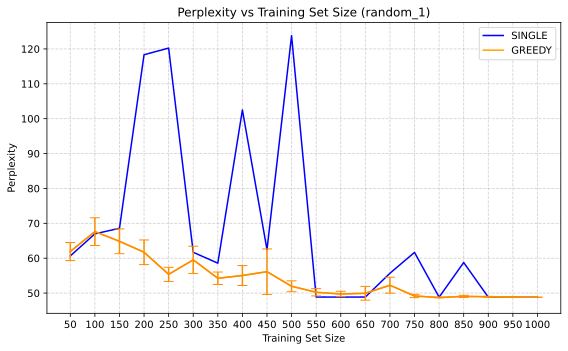

In [11]:
plot_experiment_2("random_1", trainset_sizes=[i for i in range(50, 1001, 50)])

***

## Experiment 3: All Models vs Pruned Ensemble Performance
- **Goal**: Evaluate performance of using all models vs selected subsets.
- **Presentation**: Table
- **Static Parameters**:
  - Randomization factor: `rand = 2.0`
  - Pruned size: 15 models
- **Configurations**:
  - `ALL MODELS`
  - `PRUNED MAX-IMV`
  - `PRUNED K-MEDOIDS`
  - `PRUNED AFFINITY`
  - `PRUNED AFFINITY + OUTLIER DETECTION`
- **Varying Parameter**:
  - Total number of models: [15, 50, 100, 200, 400, 600]
- **Datasets**:
  - Random Machines 3–4
  - HDFS
- **Repetitions**: 10 trials per configuration

In [ ]:
from variety import PruningMethod

def gen_and_train_exp_3(
    config: TestConfig,
    machine: PDFA,
    dataset: str,
    rand: float,
    nr_estimators: int,
    trainset_size: int,
    testset_size: int,
    runs: int,
    suffix: str = ""
):
    CLOCK.start()

    # 0) Write the experiment properties
    global_params: Dict[str, str] = {
        "experiment": "experiment_3",
        "dataset": dataset,
        "runs": str(runs),
        "models": f"SINGLE;ALL",
        "total_estimators": str(nr_estimators),
        "rand": str(rand),
        "trainset_size": str(trainset_size),
        "testset_size": str(testset_size),
        "seed": str(init_random())
    }
    results_path = RESULTS.get_dataset_dir(global_params["experiment"], global_params["dataset"])
    RESULTS.write_properties(global_params["experiment"], global_params["dataset"], global_params, suffix=suffix)
    print(f"Storing results in {results_path}")

    # 0) Define the 2 models: SINGLE and ENSEMBLE
    single_model = Model.Single("SINGLE")
    ensemble_model = Model.Greedy("ENS", rand=rand, nrestimators=nr_estimators)

    # 1) Generate all training sets and a test set
    testset = f"{config.name}_exp_{testset_size}"
    trainset_prefix = f"{config.name}_exp_{trainset_size}"
    train_runs: List[TrainRun] = []

    ff.write_testset(testset_name=testset, config=config, pdfa=machine, size=testset_size)
    for run_number in range(runs):
        trainset = trainset_prefix + f"_{run_number}"
        ff.write_trainset(trainset_name=trainset, config=config, pdfa=machine, size=trainset_size)

        train_runs.append(single_model.into_run(run_name=str(run_number), trainset_name=trainset))
        train_runs.extend(ensemble_model.split_into_parallel_runs(run_name=str(run_number), trainset_name=trainset, parts=CORES))

    print(f"Created {runs} trainsets of size {trainset_size} and testset {testset}: {CLOCK.measure()}")

    # 2) Train the models
    ff.train_models_batch(config, train_runs, number_of_cores=10)
    print(f"Trained {len(train_runs)} configurations: {CLOCK.measure()}")

    return train_runs


def diff_exp_3(
    config: TestConfig,
    dataset: str,
    nr_estimators: int,
    trainset_size: int,
    sample_size: int,
    runs: int
):
    # 1) Update properties
    props = RESULTS.read_properties("experiment_3", dataset)
    props["sample_size"] = str(sample_size)
    RESULTS.write_properties("experiment_3", dataset, props)

    # 2) Define the model to diff: ENSEMBLE
    ensemble_model = Model.Greedy("ENS", nrestimators=nr_estimators)

    # 3) Generate all diff runs
    diff_runs: List[TrainRun] = []
    for run_number in range(runs):
        trainset = f"{config.name}_exp_{trainset_size}_{run_number}"
        diff_runs.append(ensemble_model.into_run(run_name=str(run_number), trainset_name=trainset))
    # print("\n".join(map(str, diff_runs)))

    # 2) Diff the models
    diffs = ff.diff_models_batch(config, diff_runs, sample_size=sample_size)
    print(f"Diffed {len(diff_runs)} configurations: {CLOCK.measure()}")

    return diffs


def test_exp_3(
    config: TestConfig,
    dataset: str,
    nr_estimators: int,
    pruned_size: int,
    testset_size: int,
    runs: int,
    diffs: list[list[float]]
):
    # Update properties
    model_names = ["ALL", "SMALL", "MAX_IMV", "K_MEDOIDS", "AFFINITY", "MAX_IMV_OUT", "AFFINITY_NORM"]
    props = RESULTS.read_properties("experiment_3", dataset)
    props["models"] = ";".join(model_names)
    props["pruned_size"] = str(pruned_size)
    RESULTS.write_properties("experiment_3", dataset, props)

    # Define all the pruning methods
    pruners = [
        PruningMethod.MaxImv(),
        PruningMethod.KMedoidsGao(),
        PruningMethod.Affinity(),
        PruningMethod.MaxImv().DetectOutliersCluster(),
        PruningMethod.AffinityNorm()
    ]

    # Define the model to diff: ENSEMBLE
    model = Model.Greedy("ENS", nrestimators=nr_estimators, vote_strat=VoteStrat.UNIFORM)

    # Make the selections
    testset = f"{config.name}_exp_{testset_size}"
    test_runs: List[TestRun] = []

    for run_number in range(runs):

        scores_flat = diffs[run_number]
        # ALL
        test_runs.append(model.into_test(run_name=str(run_number), testset_name=testset, nrestimators=nr_estimators))
        # SMALL
        test_runs.append(model.into_test(run_name=str(run_number), testset_name=testset, nrestimators=pruned_size))

        for pruner in pruners:
            selection = pruner.prune(scores_flat, m = nr_estimators, n = pruned_size)
            print(f"{pruner.name}, data={dataset}, run_no={run_number}, pru_size={len(selection)}: {selection}")
            test_runs.append(model.into_test(run_name=str(run_number), testset_name=testset, ens_models=selection))

    results_flat = ff.test_models_batch(config, test_runs)
    results = reshape_scores(results_flat, len(model_names))

    RESULTS.write_run_results(
        "experiment_3",
        dataset,
        model_names,
        results
    )

In [6]:
# Perform EXPERIMENT 3. on all datasets
exp_3_random_configs = [
    (1, 300, 1500),
    (2, 300, 1500),
    (3, 400, 1500)
]

In [ ]:

for i, trainset_size, testset_size in exp_3_random_configs:

    gen_and_train_exp_3(
        config=ff.create_standard_config(f"random_{i}_exp_3", dir="random"),
        machine=RANDOM_MACHINE(i),
        dataset=f"random_{i}",
        rand=2.5,
        nr_estimators=200,
        trainset_size=trainset_size,
        testset_size=testset_size,
        runs=10
    )

Storing results in ./../results/experiment_3\random_1
Created 10 trainsets of size 300 and testset random_1_exp_3_exp_1500: 0m 0s
Trained 2010 configurations: 6m 42s
Storing results in ./../results/experiment_3\random_2
Created 10 trainsets of size 300 and testset random_2_exp_3_exp_1500: 0m 0s
Trained 2010 configurations: 5m 6s
Storing results in ./../results/experiment_3\random_3
Created 10 trainsets of size 400 and testset random_3_exp_3_exp_1500: 0m 0s
Trained 2010 configurations: 10m 30s


In [46]:
# Diff all the runs and configurstions
for i, trainset_size, testset_size in exp_3_random_configs:

    diffs = diff_exp_3(
        config=ff.create_standard_config(f"random_{i}_exp_3", dir="random"),
        dataset=f"random_{i}",
        nr_estimators=200,
        trainset_size=trainset_size,
        sample_size=700,
        runs=10
    )
    CACHE.save(key=3000 + i, data=diffs, to_disk=True)


TrainRun(model=Model(model_type=<ModelType.ENSEMBLE: 'ensemble'>, model_name='ENS', model_file='ENS', nrestimators=200, random_factor=1.0, ens_mode=<EnsMode.GREEDY: 'greedy'>, vote_strat=<VoteStrat.UNIFORM: 'uniform'>), run_name='ENS_0', nrestimators=200, trainset_name='random_1_exp_3_exp_300_0', first_id=0, continue_work=False)
TrainRun(model=Model(model_type=<ModelType.ENSEMBLE: 'ensemble'>, model_name='ENS', model_file='ENS', nrestimators=200, random_factor=1.0, ens_mode=<EnsMode.GREEDY: 'greedy'>, vote_strat=<VoteStrat.UNIFORM: 'uniform'>), run_name='ENS_1', nrestimators=200, trainset_name='random_1_exp_3_exp_300_1', first_id=0, continue_work=False)
TrainRun(model=Model(model_type=<ModelType.ENSEMBLE: 'ensemble'>, model_name='ENS', model_file='ENS', nrestimators=200, random_factor=1.0, ens_mode=<EnsMode.GREEDY: 'greedy'>, vote_strat=<VoteStrat.UNIFORM: 'uniform'>), run_name='ENS_2', nrestimators=200, trainset_name='random_1_exp_3_exp_300_2', first_id=0, continue_work=False)
TrainRu

In [9]:
# Test all the runs
for i, _, testset_size in exp_3_random_configs:

    diffs = CACHE.load(key=3000 + i, from_disk=True)
    
    test_exp_3(
        config=ff.create_standard_config(f"random_{i}_exp_3", dir="random"),
        dataset=f"random_{i}",
        nr_estimators=200,
        pruned_size=20,
        testset_size=testset_size,
        runs=10,
        diffs = diffs
    )

MAX-IMV, data=random_1, run_no=0, pru_size=20: [34, 38, 48, 62, 68, 69, 72, 74, 76, 79, 87, 90, 109, 114, 122, 136, 137, 186, 188, 196]
KMEDOIDS-GAO, data=random_1, run_no=0, pru_size=20: [ 42 154 167 186  91   0 146  40  92 165 184  25  66 152  34 159   5  52
 185  96]
AFFINITY, data=random_1, run_no=0, pru_size=14: [0, 5, 40, 42, 52, 66, 91, 96, 146, 152, 154, 159, 165, 185]
MAX-IMV CLUSTER, data=random_1, run_no=0, pru_size=20: [34, 38, 48, 62, 68, 69, 72, 74, 76, 79, 87, 90, 109, 114, 122, 136, 137, 186, 188, 196]
[np.float64(50.20983), np.float64(48.18150000000001), np.float64(32.09569), np.float64(53.687659999999994), np.float64(41.12533), np.float64(33.6988), np.float64(47.20060000000001), np.float64(46.599160000000005), np.float64(56.816419999999994), np.float64(42.781620000000004), np.float64(37.724250000000005), np.float64(48.22542), np.float64(56.26356000000001), np.float64(49.50564), np.float64(42.98133), np.float64(46.582649999999994), np.float64(53.14468), np.float64(56.8

In [14]:
def generate_exp_3_table(df: pd.DataFrame) -> str:

    # Compute mean and std per configuration
    summary = df.groupby(['dataset', 'train_size', 'model'])['score'].agg(['mean', 'std']).reset_index()

    # Determine true best score per (dataset) over all runs/models
    best_scores = df.groupby(['dataset'])['score'].min().reset_index()
    best_scores = best_scores.rename(columns={'score': 'best_score'})

    # Merge with summary
    summary = summary.merge(best_scores, on=['dataset'])

    # Compute growth to best
    summary['growth'] = summary['mean'] - summary['best_score']

    # Format "mean ± std" for growth
    summary['growth_fmt'] = summary.apply(lambda row: f"{row['growth']:.1f} \\pm {row['std']:.1f}", axis=1)
    print(summary)

    # Format for best score
    summary['best_score_fmt'] = summary.apply(lambda row: f"{row['best_score']:.1f}", axis=1)

    # Pivot to wide format
    pivot = summary.pivot(index=['dataset', 'train_size', 'best_score_fmt'], columns='model', values='growth_fmt').reset_index()
    pivot = pivot.sort_values(by=['dataset', 'train_size'])

    # Define the model order
    model_names = ["ALL", "SMALL", "MAX_IMV", "K_MEDOIDS", "AFFINITY_NORM"]
    pivot = pivot[['dataset', 'train_size', 'best_score_fmt'] + model_names]


    # Build multi-index header
    column_tuples: List[Tuple[str, str]] = [
        ("Dataset", ""),
        ("Train size", ""),
        ("Best score", ""),
    ] + [
        ("Avg. perplexity growth to best", name) for name in model_names
    ]
    pivot.columns = pd.MultiIndex.from_tuples(column_tuples)

    # Generate LaTeX
    latex_table = pivot.to_latex(index=False, multicolumn=True, multicolumn_format='c', escape=False)

    return latex_table


In [15]:

exp_3_datasets = ["random_1", "random_2", "random_3"]

exp_3_df = read_results_into_df("experiment_3", exp_3_datasets)
exp_3_table = generate_exp_3_table(exp_3_df)
RESULTS.write_latex_table("experiment_3", exp_3_table)

     dataset  train_size          model       mean        std  best_score  \
0   random_1         300       AFFINITY   74.96189  10.239525     61.4627   
1   random_1         300  AFFINITY_NORM   74.30104  10.212704     61.4627   
2   random_1         300            ALL   71.15045   5.109048     61.4627   
3   random_1         300      K_MEDOIDS   73.95197   9.588514     61.4627   
4   random_1         300        MAX_IMV   74.64319   8.752777     61.4627   
5   random_1         300    MAX_IMV_OUT   75.22588   7.938775     61.4627   
6   random_1         300          SMALL   76.40629  10.110905     61.4627   
7   random_2         300       AFFINITY  108.93990   7.070194     98.1390   
8   random_2         300  AFFINITY_NORM  107.48401   6.579501     98.1390   
9   random_2         300            ALL  110.29590   6.788637     98.1390   
10  random_2         300      K_MEDOIDS  108.75251   6.723589     98.1390   
11  random_2         300        MAX_IMV  106.87557   4.683469     98.1390   